<a href="https://www.kaggle.com/code/ahmedrushdi/rl-pong-ddqn?scriptVersionId=122945594" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install gym[atari,accept-rom-license] #--quiet
!pip install pygame --quiet
!pip install pyvirtualdisplay --quiet
# !pip install ale-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 KB 25.8 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - \ | / - \ done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 21.2 MB/s eta 0:00:00
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.0-py3-none-any.whl size=446671 sha256=d5d198e2b6b96e0c9175178154eabf31c8d5e8e673a7a303c991226d2212e696
  Stored in directory: /root/.cache/pip/wheels/48/28/05/06355ef9952c3ef81107adf46a1bbb5df4c6154bc9085f53f3
Successfully built AutoROM.accept-rom-license


In [2]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()


from matplotlib import pyplot as plt, animation
%matplotlib inline
from IPython import display

def create_anim(frames, dpi, fps):
    plt.figure(figsize=(frames[0].shape[1] / dpi, frames[0].shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(frames[0])
    def setup():
        plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, init_func=setup, frames=len(frames), interval=fps)
    return anim

def display_anim(frames, dpi=72, fps=50):
    anim = create_anim(frames, dpi, fps)
    return anim.to_jshtml()

def save_anim(frames, filename, dpi=72, fps=50):
    anim = create_anim(frames, dpi, fps)
    anim.save(filename)

In [3]:
from IPython.display import clear_output
import gym
import numpy as np
from tqdm.notebook import tqdm
from tensorflow import keras
import tensorflow as tf
from collections import deque
import random
from keras.backend import int_shape
from tensorflow.keras.models import load_model
import psutil
import glob

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:585: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:637: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.bool,
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py:108: DeprecationWarning: `np.object` is a deprecated ali

In [4]:
env = gym.make('PongNoFrameskip-v4')
env = gym.wrappers.AtariPreprocessing(env, noop_max=30, frame_skip=4, screen_size=84, terminal_on_life_loss=False, grayscale_obs=True, grayscale_newaxis=False, scale_obs=True)
env = gym.wrappers.FrameStack(env, 4)

A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


In [5]:
env.action_space

Discrete(6)

In [6]:
env.observation_space

Box(0.0, 1.0, (4, 84, 84), float32)

In [7]:
# number of frames to run
# NUM_FRAMES = 400000

#number of episodes to run
NUM_EPISODES = 100

#initial episode to continue training (0 if didn't train)
INIT_EPISODE = int(glob.glob('/kaggle/input/pongmodel/model*')[0].split('_')[1].split(".")[0])

#max iterations per run
MAX_ITERATIONS = 1000


#epsilon for choosing action
eps = 1 
eps_decay = 0.99

eps = eps*(eps_decay**INIT_EPISODE)

#discount factor for future utility
discount_factor = 0.97

#batch size for exp replay
batch_size = 32

#max memory stored for exp replay
MAX_MEMORY =  100000         #int(NUM_FRAMES/40)

#initial population of memory using random policy
INIT_MEMORY = int(MAX_MEMORY*0.8)

#update interval to use target network
TARGET_C = 200              #int(NUM_FRAMES/1000)
print(eps)
print(MAX_MEMORY)
print(INIT_MEMORY)
print(TARGET_C)

4.317124741065786e-05
100000
80000
200


In [8]:
class DQNAgent:
    def __init__(self, state_size, action_size):
#         import pdb; pdb.set_trace()
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=MAX_MEMORY)
        self.gamma = discount_factor    # discount rate
        self.epsilon = eps  # exploration rate
#         self.epsilon_min = eps_min
        self.epsilon_decay = eps_decay
        self.learning_rate = 0.00025
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
        
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
    def _build_model(self):
        model = keras.Sequential(
            [
                keras.layers.Permute((2,3,1), input_shape=self.state_size),
                keras.layers.Conv2D(16, kernel_size=(8, 8), strides=4, activation="relu",),
                keras.layers.Conv2D(32, kernel_size=(4, 4), strides=2, activation="relu"),
                keras.layers.Flatten(),
                keras.layers.Dense(256, activation="relu"),
                keras.layers.Dense(self.action_size, activation="linear"),
            ]
        )
        model.compile(loss='mse',
              optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((np.expand_dims(state, axis=0), action, reward, np.expand_dims(next_state, axis=0), done))

    #get action
    def act(self, state):
        #select random action with prob=epsilon else action=maxQ
#         import pdb; pdb.set_trace()
        state = (np.expand_dims(state, axis=0))
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values)
    
    def replay(self, batch_size):
        #sample random transitions
        
        state, action, reward, next_state, done = zip(*random.sample(self.memory, batch_size))
        state = np.concatenate(state)
        next_state = np.concatenate(next_state)
        action = np.array(action)
        reward = np.array(reward)
        done = np.array(done)
        Q_next=self.model.predict(next_state)
        states_target_q_values = self.target_model.predict(state)
        action_i = (np.arange(batch_size),action)
        n_action_i = (np.arange(batch_size),np.argmax(Q_next, axis=1))
#         import pdb; pdb.set_trace()
        target = reward + self.gamma * Q_next[n_action_i] * (1 - done)
        states_target_q_values[action_i] = target
        self.model.fit(state,states_target_q_values,epochs=1, verbose=0)
        
        
    def train(self, n_episodes, n_iterations):
        
        self.init_mem(INIT_MEMORY)
        scores = []
        iterations = []
        for i in tqdm(range(n_episodes), desc='Episodes'):
            state = env.reset()
            done = False
            score = 0
            frames = 0
            t = tqdm(range(n_iterations), leave=False, desc='iterations', total = 1000)
            for j in t:
                action = self.act(state)
                next_state, reward, done, info = env.step(action)
                self.remember(state, action, reward, next_state, done)
#                 if (j + 1)% (batch_size//4) == 0:
                self.replay(batch_size)
                if j % TARGET_C == 0:
                    
                    self.update_target_model()
                state = next_state
                score += reward
                self.epsilon *= self.epsilon_decay
                if done:
                    t.container.close()
                    iterations.append(j+1)
                    break
            scores.append(score)
            self.save_models()
            print(f'EP{INIT_EPISODE+i}: Done with status n_iter: {j+1}, mem_size: {len(self.memory)} {psutil.virtual_memory()[2]}%, score: {score}')
        return scores, iterations
    
    def init_mem(self, mem_n):
        for i in tqdm(range(mem_n//1000), desc = 'initializing memory'):
            state = env.reset()

            done = False
            t = tqdm(range(1000), leave=False, desc='iterations')
            for j in t:

                action = self.act(state)

                next_state, reward, done, info = env.step(action)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                if done:
                    t.container.close()
                    break
#         print(len(self.memory))
                
        
    def save_models(self):
        self.model.save(f'/kaggle/working/model_{INIT_EPISODE+NUM_EPISODES}.h5')        
        self.target_model.save(f'/kaggle/working/target_model_{INIT_EPISODE+NUM_EPISODES}.h5')
    
    def load_models(self, m_link, tm_link):
        self.model = load_model(m_link)        
        self.target_model = load_model(tm_link)



In [9]:
agent = DQNAgent(env.reset().shape,env.action_space.n)
# agent.load_models("../input/pongmodel/model.h5","../input/pongmodel/target_model.h5")
agent.load_models(f"../input/pongmodel/model_{INIT_EPISODE}.h5",f"../input/pongmodel/target_model_{INIT_EPISODE}.h5")

initializing memory:   0%|          | 0/80 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1000: Done with status n_iter: 1000, mem_size: 81000 59.7%, score: 11.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1001: Done with status n_iter: 1000, mem_size: 82000 60.5%, score: 11.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1002: Done with status n_iter: 1000, mem_size: 83000 61.1%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1003: Done with status n_iter: 1000, mem_size: 84000 61.9%, score: 11.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1004: Done with status n_iter: 1000, mem_size: 85000 62.5%, score: 7.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1005: Done with status n_iter: 1000, mem_size: 86000 63.2%, score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1006: Done with status n_iter: 1000, mem_size: 87000 64.0%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1007: Done with status n_iter: 1000, mem_size: 88000 64.5%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1008: Done with status n_iter: 1000, mem_size: 89000 65.2%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1009: Done with status n_iter: 1000, mem_size: 90000 66.0%, score: 10.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1010: Done with status n_iter: 1000, mem_size: 91000 66.6%, score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1011: Done with status n_iter: 1000, mem_size: 92000 67.4%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1012: Done with status n_iter: 1000, mem_size: 93000 68.1%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1013: Done with status n_iter: 1000, mem_size: 94000 68.7%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1014: Done with status n_iter: 1000, mem_size: 95000 69.4%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1015: Done with status n_iter: 1000, mem_size: 96000 70.1%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1016: Done with status n_iter: 1000, mem_size: 97000 70.7%, score: 9.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1017: Done with status n_iter: 1000, mem_size: 98000 71.5%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1018: Done with status n_iter: 1000, mem_size: 99000 72.1%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1019: Done with status n_iter: 1000, mem_size: 100000 73.0%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1020: Done with status n_iter: 1000, mem_size: 100000 73.0%, score: 3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1021: Done with status n_iter: 1000, mem_size: 100000 73.0%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1022: Done with status n_iter: 1000, mem_size: 100000 72.9%, score: 10.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1023: Done with status n_iter: 1000, mem_size: 100000 73.0%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1024: Done with status n_iter: 1000, mem_size: 100000 72.9%, score: 11.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1025: Done with status n_iter: 1000, mem_size: 100000 73.0%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1026: Done with status n_iter: 1000, mem_size: 100000 73.1%, score: 8.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1027: Done with status n_iter: 1000, mem_size: 100000 73.1%, score: 11.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1028: Done with status n_iter: 1000, mem_size: 100000 73.0%, score: 11.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1029: Done with status n_iter: 1000, mem_size: 100000 73.0%, score: 10.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1030: Done with status n_iter: 1000, mem_size: 100000 73.0%, score: 9.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1031: Done with status n_iter: 1000, mem_size: 100000 73.0%, score: 10.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1032: Done with status n_iter: 1000, mem_size: 100000 73.0%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1033: Done with status n_iter: 1000, mem_size: 100000 73.1%, score: 10.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1034: Done with status n_iter: 1000, mem_size: 100000 73.1%, score: 5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1035: Done with status n_iter: 1000, mem_size: 100000 73.1%, score: 9.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1036: Done with status n_iter: 1000, mem_size: 100000 73.0%, score: 9.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1037: Done with status n_iter: 1000, mem_size: 100000 73.1%, score: 9.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1038: Done with status n_iter: 1000, mem_size: 100000 73.1%, score: 9.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1039: Done with status n_iter: 1000, mem_size: 100000 73.1%, score: 9.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1040: Done with status n_iter: 1000, mem_size: 100000 73.1%, score: 6.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1041: Done with status n_iter: 1000, mem_size: 100000 73.0%, score: 10.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1042: Done with status n_iter: 1000, mem_size: 100000 73.1%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1043: Done with status n_iter: 1000, mem_size: 100000 73.1%, score: 11.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1044: Done with status n_iter: 1000, mem_size: 100000 73.0%, score: 8.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1045: Done with status n_iter: 1000, mem_size: 100000 73.1%, score: 10.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1046: Done with status n_iter: 1000, mem_size: 100000 73.1%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1047: Done with status n_iter: 1000, mem_size: 100000 73.2%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1048: Done with status n_iter: 1000, mem_size: 100000 73.1%, score: 5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1049: Done with status n_iter: 1000, mem_size: 100000 73.2%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1050: Done with status n_iter: 1000, mem_size: 100000 73.0%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1051: Done with status n_iter: 1000, mem_size: 100000 73.1%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1052: Done with status n_iter: 1000, mem_size: 100000 73.1%, score: 10.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1053: Done with status n_iter: 1000, mem_size: 100000 73.1%, score: 11.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1054: Done with status n_iter: 1000, mem_size: 100000 73.1%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1055: Done with status n_iter: 1000, mem_size: 100000 73.1%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1056: Done with status n_iter: 1000, mem_size: 100000 73.1%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1057: Done with status n_iter: 1000, mem_size: 100000 73.2%, score: 10.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1058: Done with status n_iter: 1000, mem_size: 100000 73.2%, score: 9.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1059: Done with status n_iter: 1000, mem_size: 100000 73.2%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1060: Done with status n_iter: 1000, mem_size: 100000 73.1%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1061: Done with status n_iter: 1000, mem_size: 100000 73.1%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1062: Done with status n_iter: 1000, mem_size: 100000 73.2%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1063: Done with status n_iter: 1000, mem_size: 100000 73.2%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1064: Done with status n_iter: 1000, mem_size: 100000 73.2%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1065: Done with status n_iter: 1000, mem_size: 100000 73.2%, score: 9.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1066: Done with status n_iter: 1000, mem_size: 100000 73.2%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1067: Done with status n_iter: 1000, mem_size: 100000 73.2%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1068: Done with status n_iter: 1000, mem_size: 100000 73.2%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1069: Done with status n_iter: 1000, mem_size: 100000 73.2%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1070: Done with status n_iter: 1000, mem_size: 100000 73.2%, score: 11.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1071: Done with status n_iter: 1000, mem_size: 100000 73.2%, score: 10.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1072: Done with status n_iter: 1000, mem_size: 100000 73.1%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1073: Done with status n_iter: 1000, mem_size: 100000 73.1%, score: 10.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1074: Done with status n_iter: 1000, mem_size: 100000 73.2%, score: 11.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1075: Done with status n_iter: 1000, mem_size: 100000 73.2%, score: 8.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1076: Done with status n_iter: 1000, mem_size: 100000 73.3%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1077: Done with status n_iter: 1000, mem_size: 100000 73.3%, score: 5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1078: Done with status n_iter: 1000, mem_size: 100000 73.2%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1079: Done with status n_iter: 1000, mem_size: 100000 73.3%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1080: Done with status n_iter: 1000, mem_size: 100000 73.2%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1081: Done with status n_iter: 1000, mem_size: 100000 73.1%, score: 10.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1082: Done with status n_iter: 1000, mem_size: 100000 73.2%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1083: Done with status n_iter: 1000, mem_size: 100000 73.2%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1084: Done with status n_iter: 1000, mem_size: 100000 73.3%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1085: Done with status n_iter: 1000, mem_size: 100000 73.2%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1086: Done with status n_iter: 1000, mem_size: 100000 73.2%, score: 7.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1087: Done with status n_iter: 1000, mem_size: 100000 73.3%, score: 11.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1088: Done with status n_iter: 1000, mem_size: 100000 73.3%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1089: Done with status n_iter: 1000, mem_size: 100000 73.3%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1090: Done with status n_iter: 1000, mem_size: 100000 73.3%, score: 11.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1091: Done with status n_iter: 1000, mem_size: 100000 73.3%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1092: Done with status n_iter: 1000, mem_size: 100000 73.3%, score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1093: Done with status n_iter: 1000, mem_size: 100000 73.3%, score: 11.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1094: Done with status n_iter: 1000, mem_size: 100000 73.3%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1095: Done with status n_iter: 1000, mem_size: 100000 73.2%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1096: Done with status n_iter: 1000, mem_size: 100000 73.3%, score: 11.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1097: Done with status n_iter: 1000, mem_size: 100000 73.3%, score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1098: Done with status n_iter: 1000, mem_size: 100000 73.3%, score: 11.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1099: Done with status n_iter: 1000, mem_size: 100000 73.3%, score: 12.0


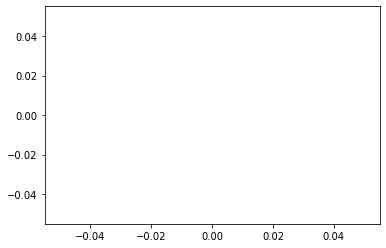

In [10]:
scores, n_iters = agent.train(NUM_EPISODES, MAX_ITERATIONS)
plt.plot(n_iters)

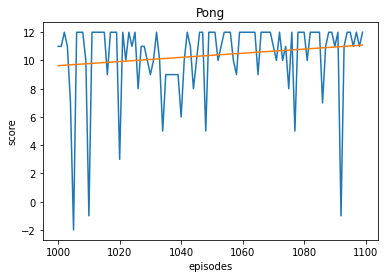

In [11]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

# sns.set()
x = range(INIT_EPISODE,NUM_EPISODES+INIT_EPISODE)
plt.plot(x,scores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Pong')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(x,y_pred)
plt.show()

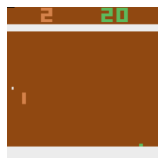

In [12]:
import cv2
def animate():
    frames = []
    state = env.reset()
    done = False
    while not done:
        frames.append(cv2.resize(env.render(mode='rgb_array'), (200, 200)))
        action = np.argmax(agent.model.predict(np.expand_dims(state,axis = 0)), axis=1)[0]
        state, _, done, _ = env.step(action)
    return frames
display.HTML(display_anim(animate(),fps = 24))